In [21]:
import nltk
from nltk.sentiment import SentimentAnalyzer

from dateutil.parser import parse

import pytz

from itertools import groupby

import matplotlib.pyplot as plt

import numpy as np

from random import randint

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD

from prepare_data import retrieve_data

%matplotlib inline

In [22]:
data = retrieve_data()
candidates = data.keys()

# Word Frequency Comparisons

In [23]:
stopwords = nltk.corpus.stopwords.words('english') + ["http", "URL", "https"]
words = [(candidate, w) for candidate in data
         for m in data[candidate]["messages"]
         for w in nltk.word_tokenize(m["body"]) 
         if w.isalpha() and w.lower() not in stopwords]

cfd = nltk.ConditionalFreqDist(words)

In [24]:
for k in cfd.keys():
    print(k)
    print([e[0] for e in cfd[k].most_common(10)])
    print()

Sanders
['Bernie', 'campaign', 'like', 'one', 'important', 'political', 'billionaires', 'supporters', 'Congress', 'reach']

Christie
['Trump', 'America', 'Town', 'Hall', 'Christie', 'President', 'PM', 'Make', 'Great', 'email']

Paul
['PM', 'NH', 'RSVP', 'Rand', 'Street', 'Paul', 'January', 'Begins', 'Town', 'Hall']

Carson
['Carson', 'America', 'emails', 'email', 'Ben', 'President', 'need', 'preferences', 'make', 'support']

Clinton
['EMILY', 'List', 'candidate', 'candidates', 'women', 'go', 'email', 'sent', 'tax', 'gifts']

Fiorina
['Carly', 'right', 'help', 'fight', 'campaign', 'people', 'political', 'CARLY', 'New', 'take']

Kasich
['Kasich', 'John', 'URL', 'America', 'Gov', 'January', 'please', 'message', 'help', 'email']

Trump
['Trump', 'Donald', 'President', 'New', 'NH', 'campaign', 'receiving', 'email', 'sent', 'Hampshire']

Cruz
['Cruz', 'Ted', 'br', 'URL', 'style', 'CRUZ', 'Trump', 'please', 'Friend', 'Iowa']

Rubio
['Marco', 'Rubio', 'Friend', 'emailxjsmith', 'message', 'camp

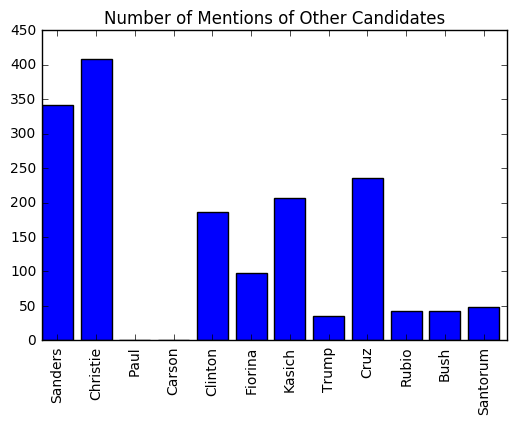

In [25]:
candidate_mentions = [(k, o, cfd[k][o]) for k in cfd.keys() for o in candidates]
other_mentions = filter(lambda x: x[0] != x[1], candidate_mentions)
num_other_mentions = [(k, sum([x[2] for x in z])) for k,z in groupby(other_mentions, key=lambda x: x[0])]
fig, ax = plt.subplots()
indices = np.arange(len(num_other_mentions))
ax.bar(indices, [x[1] for x in num_other_mentions], .8)
ax.set_xticks(indices + .4)
ax.set_xticklabels([x[0] for x in num_other_mentions], rotation='vertical')
plt.title("Number of Mentions of Other Candidates")
plt.show()

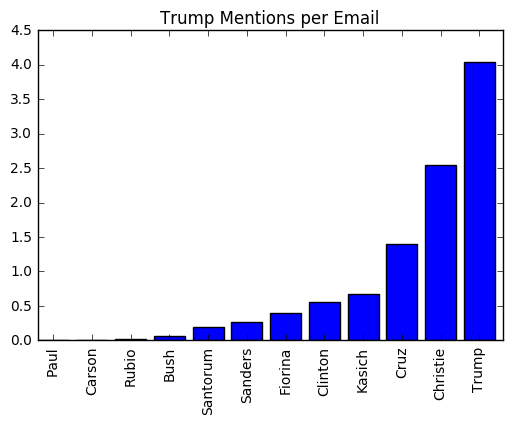

In [26]:
trump_mentions = sorted([(k,cfd[k]["Trump"] / float(len(data[k]["messages"]))) for k in cfd.keys()], key=lambda x: x[1])
fig, ax = plt.subplots()
indices = np.arange(len(trump_mentions))
ax.bar(indices, [x[1] for x in trump_mentions], .8)
ax.set_xticks(indices + .4)
ax.set_xticklabels([x[0] for x in trump_mentions], rotation='vertical')
plt.title("Trump Mentions per Email")
plt.show()

# Dimensionality Reduction

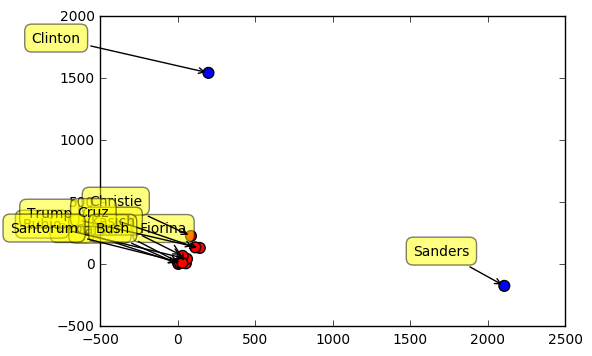

In [27]:
bow = [dict(cfd[c].most_common(20)) for c in candidates]
vec = DictVectorizer()
mat = vec.fit_transform(bow).toarray()
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(mat)
transformed = svd.fit_transform(mat)
colors = ["red" if data[k]["party"] == "Republicans" else "blue" for k in candidates]
plt.scatter(transformed[:,0], transformed[:,1], label=candidates, c=colors, s=60)


for label, x, y in zip(candidates, transformed[:, 0], transformed[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (randint(-100, 10), 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))


plt.show()

# Sentiment Analysis

In [28]:
from nltk.corpus import movie_reviews
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import extract_unigram_feats
from nltk.classify.naivebayes import NaiveBayesClassifier

n_instances = 200

pos_docs = [(list(movie_reviews.words(pos_id)), 'pos') for pos_id in movie_reviews.fileids('pos')[:n_instances]]
neg_docs = [(list(movie_reviews.words(neg_id)), 'neg') for neg_id in movie_reviews.fileids('neg')[:n_instances]]

training_docs = pos_docs+neg_docs

sentim_analyzer = SentimentAnalyzer()
all_words = sentim_analyzer.all_words(training_docs)

unigram_feats = sentim_analyzer.unigram_word_feats(all_words, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)
# Apply features to obtain a feature-value representation of our datasets
training_set = sentim_analyzer.apply_features(training_docs)

#test_set = sentim_analyzer.apply_features(testing_docs)

classifier = sentim_analyzer.train(NaiveBayesClassifier.train, training_set)
try:
    classifier.show_most_informative_features()
except AttributeError:
    print('Your classifier does not provide a show_most_informative_features() method.')


Training classifier
Most Informative Features
     contains(memorable) = True              pos : neg    =     12.3 : 1.0
        contains(subtle) = True              pos : neg    =     11.0 : 1.0
          contains(lame) = True              neg : pos    =     11.0 : 1.0
 contains(understanding) = True              pos : neg    =      9.0 : 1.0
   contains(wonderfully) = True              pos : neg    =      8.3 : 1.0
        contains(poorly) = True              neg : pos    =      8.2 : 1.0
          contains(mess) = True              neg : pos    =      8.1 : 1.0
      contains(approach) = True              pos : neg    =      7.8 : 1.0
         contains(worst) = True              neg : pos    =      7.7 : 1.0
          contains(mass) = True              pos : neg    =      7.7 : 1.0


# Time Analysis

In [29]:
about_trump = []
for k in [c for c in candidates if c != "Trump"]:
    for m in data[k]["messages"]:
        dt = parse(m["date"])
        dt = np.datetime64(dt.astimezone(pytz.utc))
        about_trump.append((k, dt, nltk.word_tokenize(m["body"]).count("Trump")))

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [30]:
import pandas as pd
series = pd.Series([a[2] for a in about_trump], [a[1] for a in about_trump])

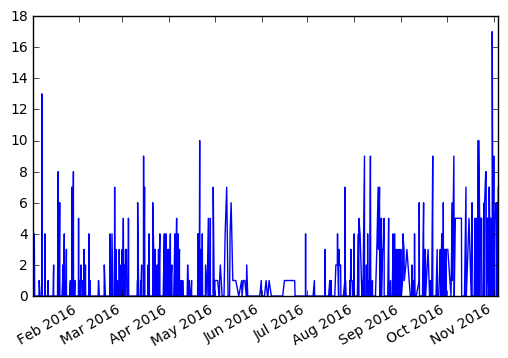

In [31]:
series.plot()

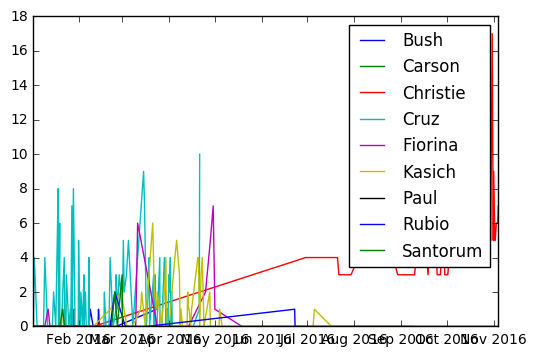

In [32]:
for key, grp in pd.DataFrame(about_trump).sort_values(1).groupby([0]):
    if key not in ["Clinton", "Sanders"]:
        plt.plot(grp[1], grp[2], label=key)
plt.legend()

# Network Graph

We can use [d3](https://d3js.org/) or [sigmajs](http://sigmajs.org/) to build a network graph that shows who mentions who

Ex: https://bl.ocks.org/mbostock/4062045

# Word Clouds

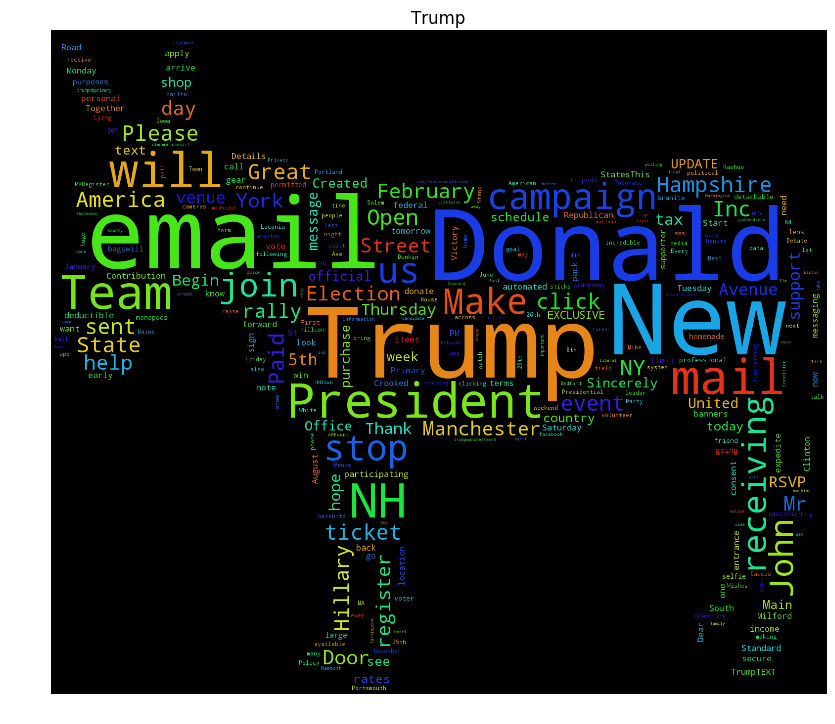

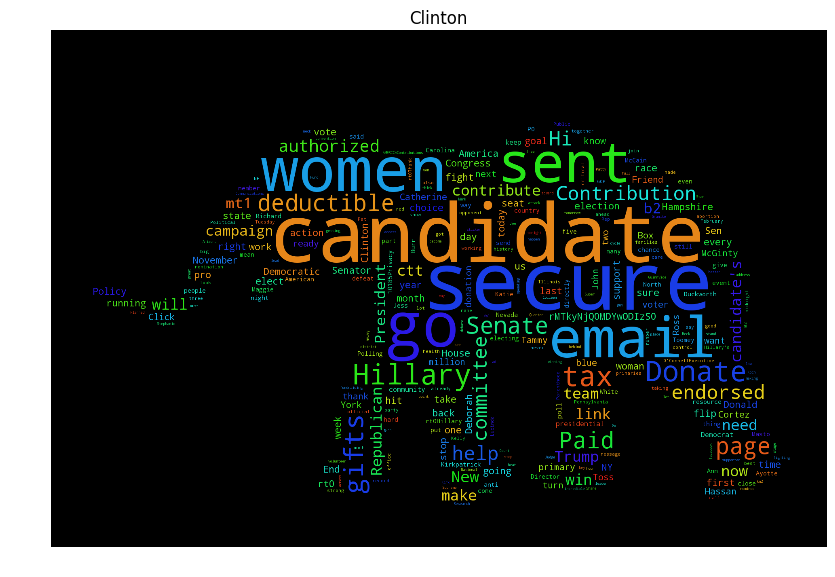

In [92]:
from PIL import Image
from os import path
import random
from wordcloud import WordCloud, STOPWORDS

useless_words = ["donaldjtrump", "eventbrite", "10022This", "98xjsmith", "org",\
                 "unsubscribe", "donaldtrump", "Inc725", "http", "https","nationbuilder", \
                 "gmail", "TrumpTEXT", "EXCLUSIVE", "EMILY's", "emilys" "emilyslist"]
stopwords = set(sw)
for word in useless_words: stopwords.add(word)


mask = np.array(Image.open("wordcloud/donkey.jpg"))

# We need to do some replacement here because it seems like 
# there is a bug in the wordcloud library causing it to not handle stopwords correctly.
text = " ".join([message["body"].replace("10022This", "").replace("Inc725","").replace("newhampshire","")\
                for message in data["Trump"]["messages"]])


wc = WordCloud(max_words=300, mask=mask, stopwords=stopwords, margin=10,random_state=1).generate(text)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Trump")
plt.imshow(wc.to_array())
plt.show()


mask = np.array(Image.open("wordcloud/elephant.jpg"))
text = " ".join([message["body"].replace("emilyslist", "").replace("EMILY's", "").replace("List", "").replace("unsubscribe","").replace("hillaryclinton","")\
                for message in data["Clinton"]["messages"]])

wc = WordCloud(max_words=300, mask=mask, stopwords=stopwords, margin=10,random_state=1).generate(text)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Clinton")
plt.imshow(wc.to_array())
plt.show()

The wordclouds above show that there is not too much diversity between the candidates' word choice, other than Hillary talking about women and Trump talking about corporations. Based solely on the Hillary wordcloud, it seems that Hillary is determined to convince people that her email server was "secure" and that she was "authorized" to use it. It also looks like Trump talked about Hillary more than Hillary talked about Trump.